<a href="https://colab.research.google.com/github/malfii/airbnb_investment/blob/main/code/03_modeling_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03-Modeling 'listing price'

In this notebook, we will use different approaches to model listing price. The target variable in this notebook is the `price` column in our cleaned data. Linear regression, Neural Network, and XGBoost are used as our estimator in this work. 

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score

# xgboost
import xgboost as xgb

#Bayesian optimizer
#!pip install scikit-optimize
from skopt import BayesSearchCV

# tensorflow/keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
# for controlling randomness in NN
import keras
keras.utils.set_random_seed(812)

# clustering
from sklearn.cluster import DBSCAN


In [2]:
df = pd.read_csv('./../data/austin_listings_clean.csv').drop(columns=['occupancy_rate'])
#df = pd.read_csv('https://raw.githubusercontent.com/malfii/airbnb_investment/main/data/austin_listings_clean.csv').drop(columns=['occupancy_rate'])
df.head(5)

,bedrooms,beds,bath,zipcode,host_is_superhost,review_scores_rating,time_quarter,has_pool,is_petfriendly,has_workspace,has_freeparking,has_gym,home_price_aprx,price
0,1,2,1.0,78702,1,4.84,Q4,0,0,0,0,0,359197.038337,101.000000
1,0,1,1.0,78704,0,4.97,Q4,0,0,1,0,0,327170.306567,91.666667
2,1,2,1.0,78704,1,4.97,Q4,0,0,1,1,0,327170.306567,159.000000
3,1,1,1.0,78741,0,4.56,Q4,0,1,0,0,0,190189.768301,48.000000
4,2,2,2.0,78702,1,5.00,Q4,0,0,1,0,0,470342.688268,123.000000


## Correlation between different features

C:\Users\masou\AppData\Local\Temp\ipykernel_8300\2086646879.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = round(df.corr(), 2)


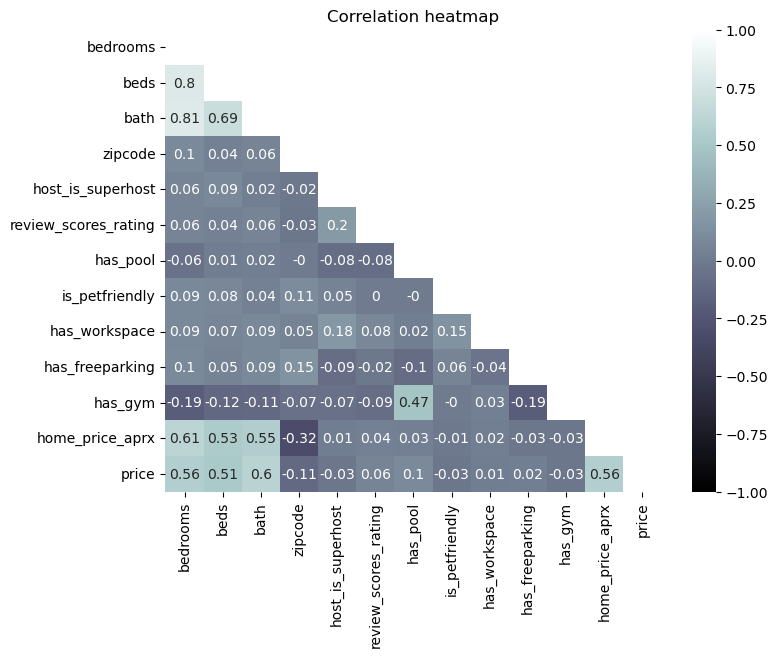

In [3]:
# plot the correlation matrix heatmap
plt.figure(figsize=(8, 6))
corr = round(df.corr(), 2)
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, cmap='bone',
            vmin = -1, vmax=1)
plt.title('Correlation heatmap');

From this graph, we can see the listing price shows the highest correlation with bedrooms, baths, and home price. Note that categorical features like the time of the listing is not considered here.

Also, looking at the correlation matrix heatmap, we can say features like beds, bedrooms, and bath are correlated to each other. Another interesting observation is the fact that the houses that have pool are more likely to have gym as well. Review ratings are usually higher when the host is experienced (superhost).

## Null model

We will start our analysis with the null model. For this, the average listing price will be considered as our prediction.

In [4]:
# create a dataframe for the null model

X = df.drop(columns=['price'])
y = df['price']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
pred = y_train.mean()
print(f'predicted price for the null model: ${int(pred)}/night')

predicted price for the null model: $246/night


In [5]:
preds_train = pred*np.ones(len(y_train))
preds_test = pred*np.ones(len(y_test))
print(f'Train data R2 = {r2_score(y_train, preds_train)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {r2_score(y_test, preds_test)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.0
Train data MAE ($) = 152
Test data R2 = -0.0002555833763804305
Test data MAE ($) = 154


__Highlights__:
- Null model predicts an average of $246 per night for listing price in Austin. It has a mean absolute error or $154 for the test data.

## Simple linear regression

We will start our modeling by building a simple linear regression model with a few features that seem to have the highest impact on listing price. The featues are `bedrooms`, `beds`, `bath`, `has_pool`, `time_quarter`, and `home_price_aprx`.

In [6]:
X = df[['bedrooms', 'beds', 'bath', 'has_pool', 'time_quarter', 'home_price_aprx']]
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
lr_simple_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('lr', LinearRegression())]
)

# fit the model
lr_simple_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_simple_pipeline.predict(X_train)
preds_test = lr_simple_pipeline.predict(X_test)

In [7]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.4562
Train data MAE ($) = 105
Test data R2 = 0.4505
Test data MAE ($) = 106


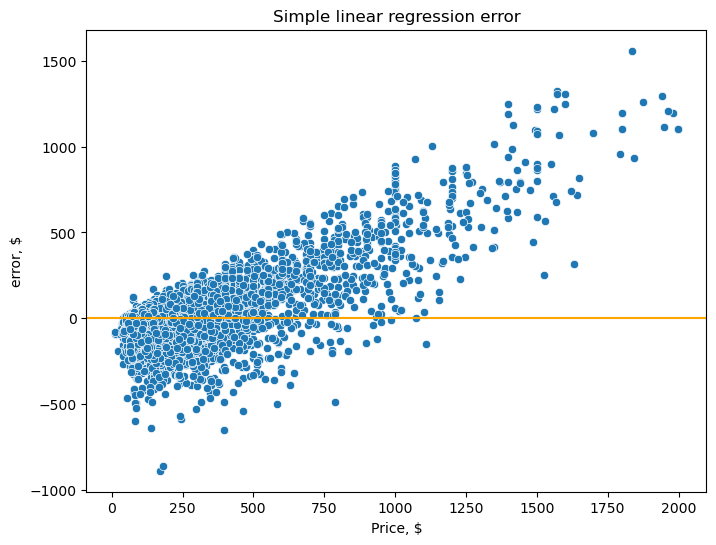

In [8]:
error = y_test - preds_test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=error)
plt.xlabel('Price, $')
plt.ylabel('error, $')
plt.title('Simple linear regression error')
plt.axhline(0, color='orange');

As we can see, the model shows issues modeling the listing prices. Let us see if adding some polynomial terms could help improve the linear model performance.  

In [9]:
X = df[['bedrooms', 'beds', 'bath', 'has_pool', 'time_quarter', 'home_price_aprx']]
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
lr_simple_poly_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('poly', PolynomialFeatures(degree=2)), # polynomial feature, quadratic
    ('lr', LinearRegression())]
)

# fit the model
lr_simple_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_simple_poly_pipeline.predict(X_train)
preds_test = lr_simple_poly_pipeline.predict(X_test)

# quadratic and first degree interaction terms created
print('New features used in our model:')
lr_simple_poly_pipeline.named_steps['poly'].get_feature_names_out([
            'time_quarter_Q2', 'time_quarter_Q3',
            'time_quarter_Q4', 'bedrooms',
            'beds', 'bath', 'has_pool','home_price_aprx'])


New features used in our model:


array(['1', 'time_quarter_Q2', 'time_quarter_Q3', 'time_quarter_Q4',
       'bedrooms', 'beds', 'bath', 'has_pool', 'home_price_aprx',
       'time_quarter_Q2^2', 'time_quarter_Q2 time_quarter_Q3',
       'time_quarter_Q2 time_quarter_Q4', 'time_quarter_Q2 bedrooms',
       'time_quarter_Q2 beds', 'time_quarter_Q2 bath',
       'time_quarter_Q2 has_pool', 'time_quarter_Q2 home_price_aprx',
       'time_quarter_Q3^2', 'time_quarter_Q3 time_quarter_Q4',
       'time_quarter_Q3 bedrooms', 'time_quarter_Q3 beds',
       'time_quarter_Q3 bath', 'time_quarter_Q3 has_pool',
       'time_quarter_Q3 home_price_aprx', 'time_quarter_Q4^2',
       'time_quarter_Q4 bedrooms', 'time_quarter_Q4 beds',
       'time_quarter_Q4 bath', 'time_quarter_Q4 has_pool',
       'time_quarter_Q4 home_price_aprx', 'bedrooms^2', 'bedrooms beds',
       'bedrooms bath', 'bedrooms has_pool', 'bedrooms home_price_aprx',
       'beds^2', 'beds bath', 'beds has_pool', 'beds home_price_aprx',
       'bath^2', 'bath has_p

In [10]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.4984
Train data MAE ($) = 99
Test data R2 = 0.4763
Test data MAE ($) = 101


We can see using polynomial features has slightly improved the performance of our linear regression.

__Highlights:__
- By using some of the most important features and interaction terms in linear regression, we can achieve an R2 of 0.47.

## Linear regression (with all features)

In  this case, we will use a simple linear regression model to predict the house price. Note that there are multiple categorical features (zipcode and time of the listing) that needs to be onehot encoded. We will use a pipeline to chain multiple operations.

In [11]:
X = df.drop(columns=['price'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
lr_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('lr', LinearRegression())]
)

# fit the model
lr_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_pipeline.predict(X_train)
preds_test = lr_pipeline.predict(X_test)



In [12]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.4792
Train data MAE ($) = 105
Test data R2 = 0.4722
Test data MAE ($) = 107


As we can see, the model is performing just ok. Let us take a look at the errors to see where we are standing.

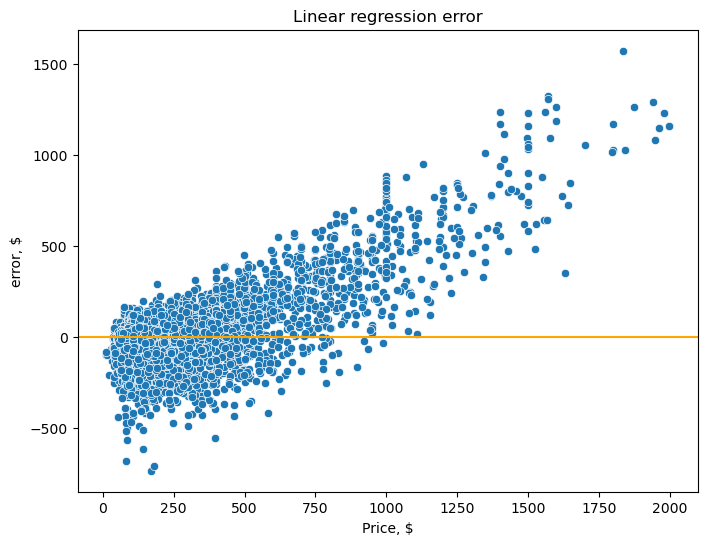

In [13]:
error = y_test - preds_test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=error)
plt.xlabel('Price, $')
plt.ylabel('error, $')
plt.title('Linear regression error')
plt.axhline(0, color='orange');

We can see that for higher prices the error becomes larger. Let us take a look at the coefficients to see if there is anything unusual there.

In [15]:
pd.DataFrame(zip(lr_pipeline.named_steps['ohe_cols'].get_feature_names_out(),lr_pipeline.named_steps['lr'].coef_ ), columns=['feature', 'coef'])

,feature,coef
0,ohe_zip__zipcode_78702,5.653861
1,ohe_zip__zipcode_78703,4.274644
2,ohe_zip__zipcode_78704,4.051681
3,ohe_zip__zipcode_78705,-8.226427
4,ohe_zip__zipcode_78717,-5.017593
5,ohe_zip__zipcode_78719,-1.313842
6,ohe_zip__zipcode_78721,-8.822327
7,ohe_zip__zipcode_78722,-2.923545
8,ohe_zip__zipcode_78723,-10.766453
9,ohe_zip__zipcode_78724,-3.992264


As we can see, the coeficients for the one hot encoded features do not show any special trend or so. Let build another linear regression model without any zipcode data since zipcode data are creating a lot of extra features.

In [16]:
X = df.drop(columns=['price', 'zipcode'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
#        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
lr_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('lr', LinearRegression())]
)

# fit the model
lr_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_pipeline.predict(X_train)
preds_test = lr_pipeline.predict(X_test)

In [17]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.4628
Train data MAE ($) = 105
Test data R2 = 0.4595
Test data MAE ($) = 107


We can see that excluding zipcode data slightly decreases our R2 score but the effect is not that much.

__Highlights:__
- Linear regression with all features included shows an average performance (R2 = 0.47)
- Removing zipcode from our linear model does not impact R2 noticably (R2 = 0.46).

## Linear regression with polynomial features (Ridge/LASSO)

We will now build a linear regression model that uses most of the original features and polynomial features as well.

In [18]:
X = df.drop(columns=['price'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
lr_poly_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('poly', PolynomialFeatures(degree=2, interaction_only=False)),
    ('lr', LinearRegression())]
)

# fit the model
lr_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_poly_pipeline.predict(X_train)
preds_test = lr_poly_pipeline.predict(X_test)



In [19]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.5674
Train data MAE ($) = 93
Test data R2 = -19419510684228.48
Test data MAE ($) = 15207272


As expected, this model shows tremendous amount of overfitting. Let us see if we can get better results buy regularizing the model. We will start with gridsearching over different ridge regularization alphas.

In [22]:
X = df.drop(columns=['price'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
ridge_poly_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('poly', PolynomialFeatures(degree=2, interaction_only=False)),
    ('ridge', Ridge())]
)

# gridsearch object
gs_ridge_poly_pipeline = GridSearchCV(ridge_poly_pipeline,
                                     param_grid={'ridge__alpha': np.logspace(2, 4, 25)},
                                      verbose = 2,
                                      cv =5,
                                      n_jobs=-1
                                     )

# fit the model
gs_ridge_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = gs_ridge_poly_pipeline.predict(X_train)
preds_test = gs_ridge_poly_pipeline.predict(X_test)

# best alpha
print(gs_ridge_poly_pipeline.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'ridge__alpha': 1211.5276586285877}


In [43]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.5598
Train data MAE ($) = 93
Test data R2 = 0.5215
Test data MAE ($) = 97


We see using ridge helps with the high variance considerably. We will also see if LASSO provides any better results.

In [42]:
X = df.drop(columns=['price'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
lasso_poly_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('poly', PolynomialFeatures(degree=2, interaction_only=False)),
    ('lasso', Lasso())]
)

# gridsearch object
gs_lasso_poly_pipeline = GridSearchCV(lasso_poly_pipeline,
                                     param_grid={'lasso__alpha': np.logspace(-1, 1, 25)},
                                      verbose = 5,
                                      cv =3,
                                      n_jobs=-1
                                     )

# fit the model
gs_lasso_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = gs_lasso_poly_pipeline.predict(X_train)
preds_test = gs_lasso_poly_pipeline.predict(X_test)

# best alpha
print(gs_lasso_poly_pipeline.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'lasso__alpha': 0.5623413251903491}


In [44]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.5598
Train data MAE ($) = 93
Test data R2 = 0.5215
Test data MAE ($) = 97


LASSO shows a performance similar to that of ridge but takes longer to run.

Before wrapping up this section, we will dig a little more into the error terms to see if we can get some information about how error is distributed and what contributes more to our error.

In [26]:
# create a new dataframe for error analysis
df_error = df.copy()
# assign predictions to train and test data
df_error['is_train'] = 1
df_error.loc[X_test.index, 'is_train'] = 0
df_error['price_pred'] = 0
df_error.loc[X_test.index, 'price_pred'] = preds_test
df_error.loc[X_train.index, 'price_pred'] = preds_train
# calcuate error terms
df_error['error_abs'] = (df_error['price'] - df_error['price_pred']).abs()
df_error['error_perc'] = df_error['error_abs'] / df_error['price'] * 100

We will first print the average of the modeling error for each of the features.

In [27]:
for i in ['bedrooms', 'beds', 'bath', 'host_is_superhost',
       'time_quarter', 'has_pool', 'is_petfriendly',
       'has_workspace', 'has_freeparking', 'has_gym']:
    print(f'\n==> Analyzing modeling errors with {i}')
    print(df_error.groupby(i).mean(numeric_only=True)[['error_abs', 'error_perc']])


==> Analyzing modeling errors with bedrooms
           error_abs  error_perc
bedrooms                        
0          44.634460   41.330766
1          52.621848   39.106106
2          80.663770   49.354582
3         118.376388   45.946123
4         174.554728   44.070683
5         249.035809   63.702498
6         278.921778   57.107178
7         265.443457   65.352671

==> Analyzing modeling errors with beds
       error_abs  error_perc
beds                        
1      52.539816   41.618489
2      68.541429   43.462041
3     100.463843   46.250394
4     129.345947   47.082425
5     146.405267   49.513002
6     176.436780   47.344567
7     183.196436   43.690591
8     222.489400   72.396878
9     198.891368   46.239882
10    212.112338   56.530796
11    259.711400   35.621839
12    244.217387   71.633381
13    233.615228   47.953405
14    232.960975   39.246918
15    278.911373   49.738599

==> Analyzing modeling errors with bath
       error_abs  error_perc
bath                 

Interesting trends we see here is that how error is affected by the number of bedrooms and beds. Also, when a house has pool, the prediction error increases 10%. Also, prediction errors are 10% smaller in cases where the host is a superhost.
Let us dive deeper into some of these features and error distribution in them.

In [28]:
df_error.groupby('bedrooms')['error_abs', 'error_perc'].mean()

C:\Users\masou\AppData\Local\Temp\ipykernel_8300\767266100.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_error.groupby('bedrooms')['error_abs', 'error_perc'].mean()


,error_abs,error_perc
bedrooms,,
0,44.634460,41.330766
1,52.621848,39.106106
2,80.663770,49.354582
3,118.376388,45.946123
4,174.554728,44.070683
5,249.035809,63.702498
6,278.921778,57.107178
7,265.443457,65.352671


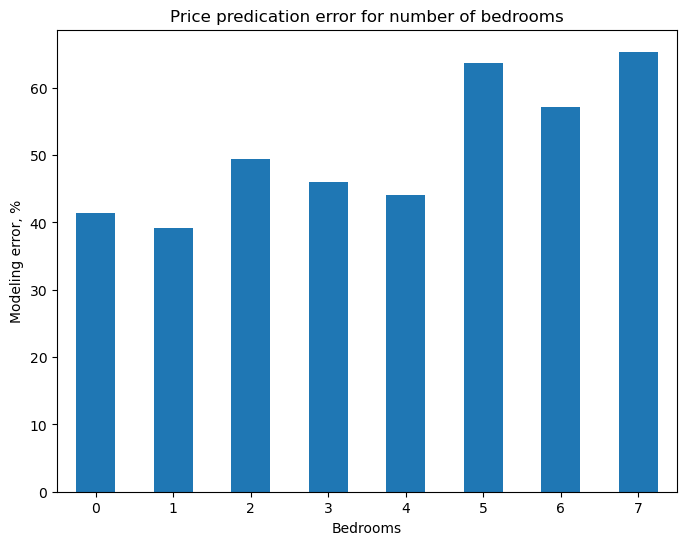

In [29]:
plt.figure(figsize=(8, 6))
df_error.groupby('bedrooms')['error_perc'].mean().plot.bar()
plt.xlabel('Bedrooms')
plt.ylabel('Modeling error, %')
plt.title('Price predication error for number of bedrooms')
plt.xticks(rotation=0);

From the above figure, we can say that the price prediction error increases when the number of bedrooms increases to 5 or more.

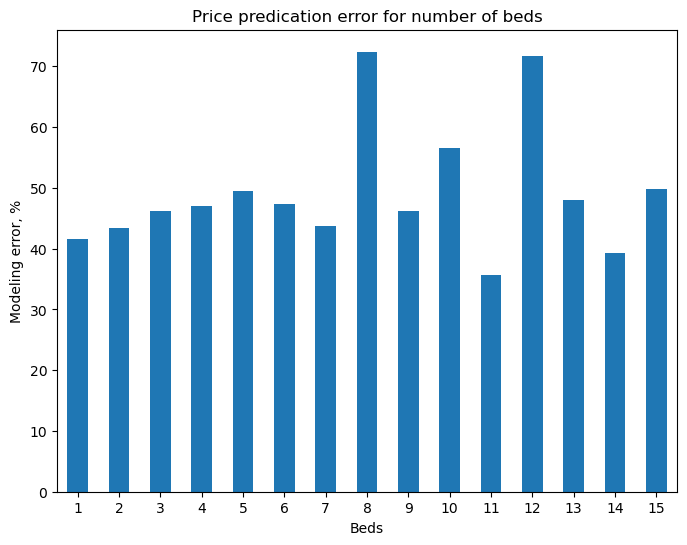

In [30]:
plt.figure(figsize=(8, 6))
df_error.groupby('beds')['error_perc'].mean().plot.bar()
plt.xlabel('Beds')
plt.ylabel('Modeling error, %')
plt.title('Price predication error for number of beds')
plt.xticks(rotation=0);

In [31]:
print('Value count for different number of beds:')
df_error['beds'].value_counts().sort_index()

Value count for different number of beds:


1      9029
2     11009
3      7507
4      4219
5      2043
6      1243
7       806
8       510
9       295
10      240
11      118
12      131
13       86
14       73
15       32
Name: beds, dtype: int64

Modeling error for the number of beds increases slowly up to 5-6 beds and then goes ups and down. We cannot draw a solide conclusion on how the error is impacted by number of beds but it should be noticed that the trend we are seeing for beds after 9 or more is not that significant as the number of listings in that range is relatively small.

The following plot shows error analysis at different zip codes (also the number of listing at each zipcode).

In [32]:
# find the number average modeling error in each zip code and create a df to plot it as well as the number of listings
zip_error = pd.concat([df_error.groupby('zipcode')['error_perc'].count().sort_values(ascending=False),
                       df_error.groupby('zipcode')['error_perc'].mean().sort_values(ascending=False)], axis=1 )
zip_error.columns = ['count', 'error_perc']
zip_error = zip_error.sort_values(by='error_perc', ascending=False)


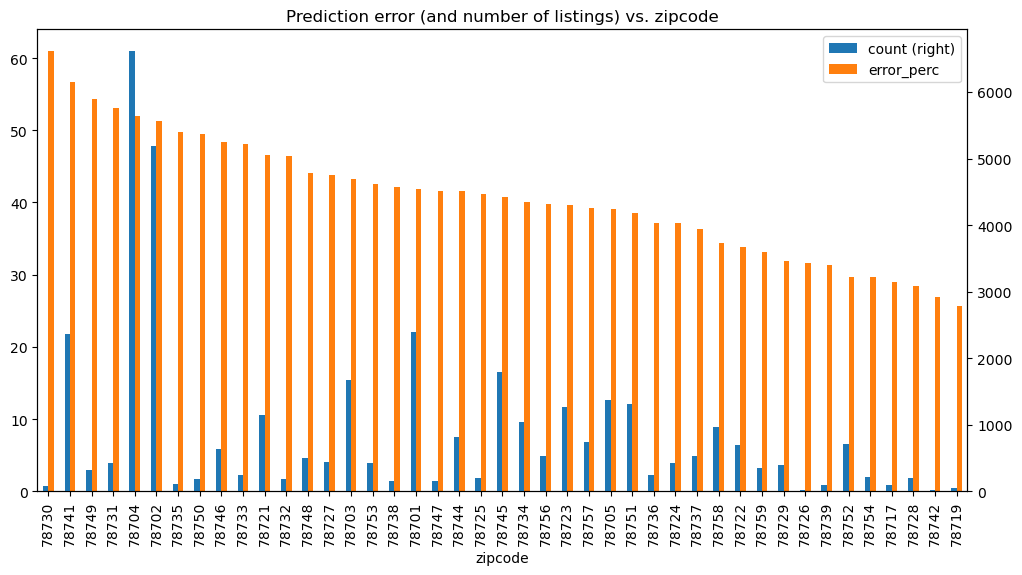

In [33]:
zip_error.plot.bar(secondary_y='count', figsize=(12, 6))
plt.title('Prediction error (and number of listings) vs. zipcode');

Zipcode analysis shows errors as high as 60% in some neighborhoods and as low as 30% in others. The number of listings in each neighborhood is ploted in this plot so that we know the error is calcualted based on how many observations. Caution should be practiced when interpreting the data from zip codes without too many listings.

At the end, let us see if we can find any meaningful correlation between our model error and the price of homes in each neighborhood.

In [37]:
df_error.head()

,bedrooms,beds,bath,zipcode,host_is_superhost,review_scores_rating,time_quarter,has_pool,is_petfriendly,has_workspace,has_freeparking,has_gym,home_price_aprx,price,is_train,price_pred,error_abs,error_perc
0,1,2,1.0,78702,1,4.84,Q4,0,0,0,0,0,359197.038337,101.000000,1,114.371996,13.371996,13.239600
1,0,1,1.0,78704,0,4.97,Q4,0,0,1,0,0,327170.306567,91.666667,1,172.332405,80.665738,87.998987
2,1,2,1.0,78704,1,4.97,Q4,0,0,1,1,0,327170.306567,159.000000,1,99.954438,59.045562,37.135573
3,1,1,1.0,78741,0,4.56,Q4,0,1,0,0,0,190189.768301,48.000000,1,105.622883,57.622883,120.047673
4,2,2,2.0,78702,1,5.00,Q4,0,0,1,0,0,470342.688268,123.000000,0,177.792941,54.792941,44.547107


C:\Users\masou\AppData\Local\Temp\ipykernel_8300\3355886998.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.scatterplot(x = df_error.groupby('home_price_aprx').mean().index, y = df_error.groupby('home_price_aprx').mean()['error_perc'])
C:\Users\masou\AppData\Local\Temp\ipykernel_8300\3355886998.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.scatterplot(x = df_error.groupby('home_price_aprx').mean().index, y = df_error.groupby('home_price_aprx').mean()['error_perc'])


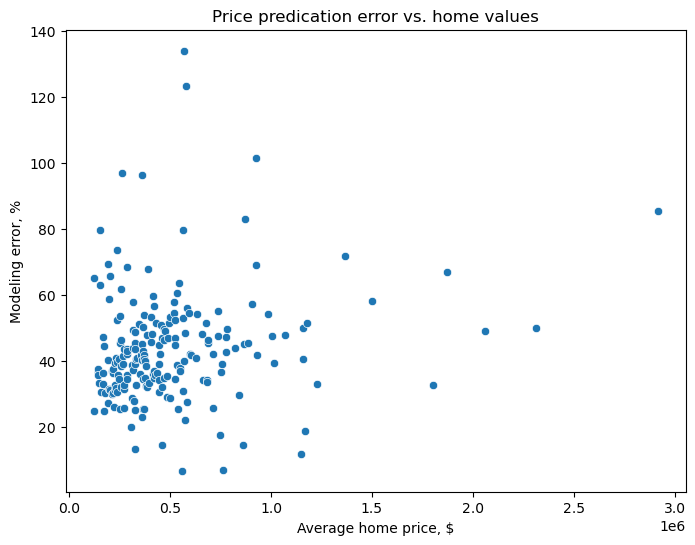

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = df_error.groupby('home_price_aprx').mean().index, y = df_error.groupby('home_price_aprx').mean()['error_perc'])
#df_error.groupby('home_price_aprx')['error_perc'].mean().sort_index(ascending=True).plot.scatter()
plt.xlabel('Average home price, $')
plt.ylabel('Modeling error, %')
plt.title('Price predication error vs. home values')
plt.xticks(rotation=0);

The above plot does not show any meaningful correlation between the average home price and the airbnb home listing price error.

Before wrapping up this section, let us use the Ridge model and see if doing log transformation on y variables would help the issue with high errors on higher listing prices we notices previously. 

In [3]:
X = df.drop(columns=['price'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

y_train = np.log10(y_train)
y_test = np.log10(y_test)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
ridge_poly_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('poly', PolynomialFeatures(degree=2, interaction_only=False)),
    ('ridge', Ridge())]
)

# gridsearch object
gs_ridge_poly_pipeline = GridSearchCV(ridge_poly_pipeline,
                                     param_grid={'ridge__alpha': np.logspace(2, 4, 25)},
                                      verbose = 1,
                                      cv =5,
                                     )

# fit the model
gs_ridge_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = gs_ridge_poly_pipeline.predict(X_train)
preds_test = gs_ridge_poly_pipeline.predict(X_test)

y_train = np.power(y_train, 10)
y_test = np.power(y_test, 10)
preds_train = np.power(preds_train, 10)
preds_test = np.power(preds_test, 10)


# best alpha
print(gs_ridge_poly_pipeline.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'ridge__alpha': 1000.0}


In [4]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.4439
Train data MAE ($) = 4796
Test data R2 = 0.3881
Test data MAE ($) = 5063


From the above results, log transforming the data did not help with better predictions.

__Highlights:__
- Using polynomial features (quadratic terms) along with regularization has improved our linear regression model (R2 = 0.52). Both Ridge and LASSO have the same performance.

_Error analysis:_
- Prediction error shows a big jump for 5 bedrooms and more.
- Prediction error for listings that have pool is 10% higher than the ones without pool.
- Prediction error for listings with a super host is 10% lower than the listings without superhost.


## Neural Networks regressor

In this section, we will try to use neural networks (NN) to build a model and estimate the listing price for airbnb houses. Since NN requires the data to be in numeric format (no categorical data), we will start our analysis by a model that only includes the numeric features so that we don't increase the dimensionality at the beginning. Please note that we have tried various combination of different hidden layers and number of nodes and the below mentioned model has given us the best performance. 

In [10]:
X = df.drop(columns=['price', 'zipcode', 'time_quarter'])
y = df['price']

# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# scale the data
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

# build the sequential nn
nn_numeric = Sequential()
# add a hidden layer
nn_numeric.add(Dense(128,
                     activation='relu',
                     input_shape=(11,)))
# add a hidden layer
nn_numeric.add(Dense(256,
                     activation='relu'))
# add a hidden layer
nn_numeric.add(Dense(128,
                     activation='relu'))
# add a hidden layer
nn_numeric.add(Dense(32,
                     activation='relu'))
# add output layer
nn_numeric.add(Dense(1,
                     activation=None))

# compile the model
nn_numeric.compile(loss='mse',
                   optimizer='adam')

# fit the model
es = EarlyStopping(patience = 5)
nn_numeric.fit(Z_train, y_train,
               epochs=200,
               batch_size=256,
               callbacks=[es],
               validation_data=(Z_test, y_test))

# predict data
preds_train = nn_numeric.predict(Z_train)
preds_test = nn_numeric.predict(Z_test)

Epoch 1/200
117/117 [==============================] - 1s 6ms/step - loss: 55508.4375 - val_loss: 30792.8926
Epoch 2/200
117/117 [==============================] - 1s 4ms/step - loss: 29424.3613 - val_loss: 29994.7188
Epoch 3/200
117/117 [==============================] - 0s 4ms/step - loss: 29020.1094 - val_loss: 29582.7168
Epoch 4/200
117/117 [==============================] - 0s 4ms/step - loss: 28489.1172 - val_loss: 29445.0391
Epoch 5/200
117/117 [==============================] - 0s 4ms/step - loss: 28001.7012 - val_loss: 29348.1797
Epoch 6/200
117/117 [==============================] - 0s 4ms/step - loss: 27677.2441 - val_loss: 29017.8301
Epoch 7/200
117/117 [==============================] - 0s 4ms/step - loss: 27349.3301 - val_loss: 28451.3398
Epoch 8/200
117/117 [==============================] - 0s 4ms/step - loss: 27073.6504 - val_loss: 28542.5586
Epoch 9/200
117/117 [==============================] - 0s 4ms/step - loss: 26878.0410 - val_loss: 28613.6270
Epoch 10/200
117/11

In [11]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.6043
Train data MAE ($) = 90
Test data R2 = 0.5334
Test data MAE ($) = 97


The best performance we got (for the current set of features) with different topographies of neural networks and various hyperparameter tuning efforts was R2 of 0.50-0.60. Now, let us include the categorical features as well and see if this makes the NN model any better.

In [12]:
X = df.drop(columns=['price'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
nn_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ])

Z_train = nn_pipeline.fit_transform(X_train)
Z_test = nn_pipeline.transform(X_test)

# build the sequential nn
nn_numeric = Sequential()
# add a hidden layer
nn_numeric.add(Dense(128,
                     activation='relu',
                     input_shape=(56,)))
# add a hidden layer
nn_numeric.add(Dense(256,
                     activation='relu'))
# add a hidden layer
nn_numeric.add(Dense(128,
                     activation='relu'))
# add a hidden layer
nn_numeric.add(Dense(32,
                     activation='relu'))
# add output layer
nn_numeric.add(Dense(1,
                     activation=None))

# compile the model
nn_numeric.compile(loss='mse',
                   optimizer='adam')

# fit the model
es = EarlyStopping(patience = 5)
nn_numeric.fit(Z_train, y_train,
               epochs=200,
               batch_size=256,
               callbacks=[es],
               validation_data=(Z_test, y_test))

# predict data
preds_train = nn_numeric.predict(Z_train)
preds_test = nn_numeric.predict(Z_test)

Epoch 1/200
117/117 [==============================] - 1s 5ms/step - loss: 54487.0000 - val_loss: 30426.2832
Epoch 2/200
117/117 [==============================] - 0s 4ms/step - loss: 28543.3457 - val_loss: 29180.0918
Epoch 3/200
117/117 [==============================] - 0s 4ms/step - loss: 27683.4629 - val_loss: 28742.0156
Epoch 4/200
117/117 [==============================] - 0s 4ms/step - loss: 27014.3516 - val_loss: 28693.5508
Epoch 5/200
117/117 [==============================] - 0s 4ms/step - loss: 26445.2363 - val_loss: 28616.7539
Epoch 6/200
117/117 [==============================] - 0s 4ms/step - loss: 26042.3516 - val_loss: 27537.0371
Epoch 7/200
117/117 [==============================] - 0s 4ms/step - loss: 25540.9492 - val_loss: 27364.7070
Epoch 8/200
117/117 [==============================] - 0s 4ms/step - loss: 25073.8750 - val_loss: 27207.2676
Epoch 9/200
117/117 [==============================] - 1s 4ms/step - loss: 24664.3711 - val_loss: 27295.4121
Epoch 10/200
117/11

In [13]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.7168
Train data MAE ($) = 73
Test data R2 = 0.5833
Test data MAE ($) = 88


By using all of the features, we were able to bump the test R2 score closer to 0.60 for modeling airbnb prices.

__Highlights:__
- Using NN with multiple hidden layers and all of the features improved the R2 score of the test data to values close to 0.60.

## XGBoost regressor

In this section, we will try to model the listing price using XGBoost. First, define the object columns as categories and then create the object and run it. 

In [3]:
df_xgb = df.copy()
# convert the type into category
df_xgb[['zipcode', 'time_quarter']] = df_xgb[['zipcode', 'time_quarter']].astype('category')

X = df_xgb.drop(columns=['price'])
y = df_xgb['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)


# create the xgb instance
xgb_reg = xgb.XGBRegressor(enable_categorical=True)

param_space = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.2, 0.4, 0.6, 0.8],
    'max_depth': [5, 8, 10], # this has significant effects on R2
    'subsample': [0.5, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [ 0.001, 0.01, 0.1, 1],
    'gamma': [0.1, 1, 3],
    'eta': [0.2, 0.5],
    'min_child_weight': [5, 7]

}
bayes_xgb_reg = BayesSearchCV(xgb_reg,
                         param_space,
                         cv=5,
                         verbose=0,
                         n_iter=50,
                         scoring='neg_mean_absolute_error',
                         random_state=42)
bayes_xgb_reg.fit(X_train, y_train)


# predict data
preds_train = bayes_xgb_reg.predict(X_train)
preds_test = bayes_xgb_reg.predict(X_test)

# parameters for the best estimator
print('=============')
print(bayes_xgb_reg.best_params_)
print(bayes_xgb_reg.best_score_)

c:\Users\masou\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\masou\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\masou\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


OrderedDict([('colsample_bytree', 1.0), ('eta', 0.2), ('gamma', 0.1), ('learning_rate', 0.1), ('max_depth', 10), ('min_child_weight', 5), ('n_estimators', 150), ('reg_alpha', 0.1), ('subsample', 0.9)])
-74.26020099242271


In [4]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.904
Train data MAE ($) = 42
Test data R2 = 0.7039
Test data MAE ($) = 72


As we can see from the results, we have been able to get a R2 score of 0.71 with XGBoost. The tree based algorithms are prone to overfitting and in order to control it, we have tried different hyperparameter tunings. `BayesSearchCV` was used to exhaust all the possible hyperparameter tunining options without increasing the runtime drastically.

We will save this model to use for our predictions.

In [7]:
# save
pickle.dump(bayes_xgb_reg, open('./../model_files/xgb_price.pkl', "wb"))

__Highlights:__
- XGBoost gives us a test R2 of 0.71 after trying different hyperparameter tuning approaches.

## Key takeaways:
- Linear regression model performs better when we consider quadratic interaction terms and use Ridge/Lasso regularization. 
- Our model strugle more for the higher home prices and also for cases with a higher number of bedrooms/baths.
- Neural networks doesn't provide that much of improvements in modeling compared to the best linear regression model and need more work.
- XGBoost performed the best with an R2 score of 0.71 on the test data. 